# Figure. Association Summary

In [1]:
import cPickle
import datetime as dt
import glob
import itertools
import os
import re
import subprocess
import sys

import cdpybio as cpb
import matplotlib
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.stats as stats
import seaborn as sns
sns.set(style='whitegrid', palette='colorblind', rc={'font.sans-serif':'Helvetica'})

%matplotlib inline

nb_name = 'figure_association_summary'

outdir = os.path.realpath('../output/{}'.format(nb_name))
if not os.path.exists(outdir):
    os.makedirs(outdir)
private_outdir = os.path.realpath('../private_output/{}'.format(nb_name))
if not os.path.exists(private_outdir):
    os.makedirs(private_outdir)

/Users/cdeboever/software/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/cdeboever/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def convert_pheno_label(x):
    """This function converts phenotype labels into a shorter labels."""
    x = x.replace('Forced_expiratory_volume_in_1-second_(FEV1)', 'FEV1')
    x = x.replace('_', ' ')
    x = x.replace(', automated reading', '')
    x = x.replace('percentage', 'pct')
    x = x.replace('Peak_expiratory_flow_(PEF)', 'PEF')
    x = x.replace('Forced_vital_capacity_(FVC)', 'FVC')
    return(x)

def clean_axis(ax):
    "Remove spines and ticks from axis"
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [56]:
allelotype_map = pd.read_csv('../data/ukb_to_asterisk_names.csv', index_col=0)

In [26]:
# There are 60 associations with posterior prob > 0.8
bma = pd.read_csv('../manuscript/bma_post_prob_sig_literature.csv')
bma = bma.drop(bma.index[-2:])
bma = bma.merge(allelotype_map, left_on='allelotype', right_index=True)

In [41]:
print('{:,} phenotypes with associations'.format(bma['phenotype'].value_counts().shape[0]))
print('{:,} alleles with associations'.format(bma['allelotype'].unique().shape[0]))

31 phenotypes with associations
30 alleles with associations


In [53]:
bma['pheno_category'] = ['cancer' in x.lower() for x in bma['phenotype']]
bma['pheno_category'] = bma['pheno_category'].replace({False: 'Not Cancer', True: 'Cancer'})

In [66]:
bma['locus'] = ('HLA-' + bma['literature_names'].apply(lambda x: x.split('*')[0]))

In [83]:
# qt_results = pd.read_excel('../output/process_data/assoc_results.xlsx', 'qt')
# qt_results = qt_results.sort_values(by='gene_name')
# qt_results.index = range(qt_results.shape[0])
# 
# bin_results = pd.read_excel('../output/process_data/assoc_results.xlsx', 'binary')

pheno_annot = pd.read_table('../data/phenotype_annotation.tsv', index_col=1)

# variant_to_gene = pd.Series(dict(zip(plot_qt_results['ID'], plot_qt_results['gene_name'])))

In [163]:
bma = bma.sort_values(by='locus', ascending=False)

In [164]:
variants = bma['literature_names'].drop_duplicates()
variants.index = range(variants.shape[0])
genes = bma['locus'].drop_duplicates()
genes.index = range(genes.shape[0])
phenos = bma['phenotype'].drop_duplicates()
phenos.index = range(phenos.shape[0])
genes_variants = bma[['literature_names', 'locus']].drop_duplicates()
genes_variants.index = range(genes_variants.shape[0])
genes_variants.columns = ['ID', 'gene_name']

ind = []
label = []
for gene in set(genes_variants['gene_name']):
    tdf = genes_variants[genes_variants['gene_name'] == gene]
    ind.append(np.mean(tdf.index))
    label.append(gene)

gene_index = pd.Series(ind, index=label)
variant_index = pd.Series(genes_variants.index, index=genes_variants['ID'])

tdf = pheno_annot.loc[set(bma['phe_ID'])][pheno_annot.columns[30:]]
# tdf.index = pheno_annot.loc[tdf.index, 'Name'].apply(lambda x: x.replace('_', ' '))
# TODO: I need to get the actual disease groupings and remove the next four lines
se = tdf.sum(axis=1)
se[se == 0]
tdf['Unknown'] = False
tdf.loc[se[se == 0].index, 'Unknown'] = True
assert tdf.sum(axis=1).sum() == tdf.shape[0]

phenotype_index = pd.DataFrame(
    {'label':[convert_pheno_label(x) for x in phenos]},
    index=phenos.values)

phenotype_index['category'] = ''
for pheno in phenotype_index.index:
    se = tdf.loc[z[pheno]]
    phenotype_index.loc[pheno, 'category'] = se[se == True].index[0].replace('_', ' ')
phenotype_index = phenotype_index.sort_values(by='category')
phenotype_index['ind'] = np.linspace(0, variant_index.shape[0] - 1, num=phenos.shape[0])
t = phenotype_index['category'].drop_duplicates()
t.index = range(t.shape[0])
pcat_color = pd.Series([sns.color_palette('Set2', t.shape[0])[i] for i in t.index],
                       index=t)

bma['variant_index'] = variant_index[bma['literature_names']].values
bma['gene_index'] = gene_index[bma['locus']].values
bma['phenotype_index'] = phenotype_index.loc[bma['phenotype'], 'ind'].values

t = list(set(bma['literature_names']))
variant_color = pd.Series([sns.color_palette()[i % len(sns.color_palette())] for i in range(len(t))],
                          index=t)

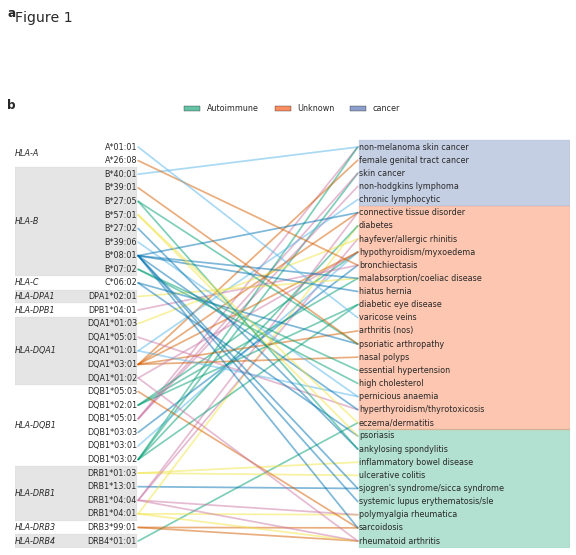

In [165]:
fs = 8

fig = plt.figure(figsize=(8, 8), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 1',
        size=14, va='top')
clean_axis(ax)
gs.tight_layout(fig, rect=[0, 0.96, 1, 1])

### Panel A (Manhattan plot)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# res,ax,colors = cpb.analysis.manhattan_plot(plot_bma, ax, p_cutoff=bma.P.max())
#, label_column='label')


gs.tight_layout(fig, rect=[0, 0.79, 1, 0.97])

### Panel B (QT overview)
gs = gridspec.GridSpec(2, 1, height_ratios=[0.07, 1])

# Make legend
ax = fig.add_subplot(gs[0, 0])
labels = pcat_color.index
rects = [plt.Rectangle((0, 0), 0, 0, fc=pcat_color[i]) for i in pcat_color.index]
lgd = ax.legend(rects, labels, loc='upper center', prop={'size': 8}, ncol=4)
clean_axis(ax)

# Make plot
ax = fig.add_subplot(gs[1, 0])

ymin = -0.5
ymax = max(len(set(bma['literature_names'])), len(set(bma['phe_ID']))) - 0.5
ax.set_ylim(0, ymax + 1)

gene_x = 0
variant_x = 0.22
pheno_x = 0.62

# Write labels
for gene in gene_index.index:
    ax.text(gene_x, gene_index[gene], gene, fontsize=fs, ha='left', va='center', style='italic')
for variant in variant_index.index:
    ax.text(variant_x, variant_index[variant], variant, fontsize=fs, ha='right', va='center')
for pheno in phenotype_index.index:
    ax.text(pheno_x, phenotype_index.loc[pheno, 'ind'], phenotype_index.loc[pheno, 'label'], 
            fontsize=fs, ha='left', va='center')
    
# Connect labels
for ind in bma.index:
    ax.plot(
        [variant_x + 0.002, pheno_x - 0.002],
        bma.loc[ind, ['variant_index', 'phenotype_index']],
        color=variant_color[bma.loc[ind, 'literature_names']],
        alpha=0.5,
    )
ax.set_xlim(0, 1)

keep = genes[0::2]
gvt = genes_variants[genes_variants['gene_name'].isin(keep)]
for gene in set(gvt['gene_name']):
    tdf = genes_variants[genes_variants['gene_name'] == gene]
    bottom = min(tdf.index)
    top = max(tdf.index) + 1
    ax.axhspan(ymin=bottom - 0.5, ymax=top - 0.5, xmin=gene_x, xmax=variant_x, color='grey', alpha=0.2)

for cat in pcat_color.index:
    tdf = phenotype_index[phenotype_index['category'] == cat]
    bottom = min(tdf['ind'])
    top = max(tdf['ind']) + 1
    ax.axhspan(ymin=bottom - 0.5, ymax=top - 0.5, xmin=pheno_x, xmax=1, color=pcat_color[cat], alpha=0.5)

ax.grid()
ax.set_ylim(ymin, ymax)
ax.set_xticks([])
ax.set_yticks([])
for sp in ax.spines.values():
    sp.set_visible(False)

gs.tight_layout(fig, rect=[0, 0, 1, 0.82], h_pad=0.01)

t = fig.text(0.005, 0.94, 'a', weight='bold', 
             size=12)
t = fig.text(0.005, 0.78, 'b', weight='bold', 
             size=12)

# plt.savefig(os.path.join(outdir, 'association_summary.pdf'))

In [ ]:
# TODO: Get disease groups for the rest of diseases
# Make lines hashed for things that have been previously reported.

In [155]:
gene_index

HLA-DPB1    18.00
HLA-C       23.00
HLA-B       16.00
HLA-A       22.00
HLA-DRB1    13.25
HLA-DRB4    16.00
HLA-DQB1     8.50
HLA-DRB3     9.00
HLA-DPA1    21.00
HLA-DQA1    14.40
dtype: float64